In [37]:
import numpy as np
from sedpy.observate import load_filters
from sedpy.observate import Filter
from prospect import prospect_args
from prospect.fitting import fit_model
from prospect.io import write_results as writer
import matplotlib.pyplot as plt
from astropy import units as u

In [38]:
run_params = {'verbose':False,
              'debug':False,
              'output_pickles': False,
              # dynesty Fitter parameters
              'nested_bound': 'multi', # bounding method
              'nested_sample': 'auto', # sampling method
              'nested_nlive_init': 300,
              'nested_nlive_batch': 300,
              'nested_bootstrap': 0,
              'nested_dlogz_init': 0.05,
              'nested_weight_kwargs': {"pfrac": 1.0},
              }

In [142]:
# --------------
# Model Definition
# --------------

def build_model(**kwargs):
    """Construct a model.  This method defines a number of parameter
    specification dictionaries and uses them to initialize a
    `models.sedmodel.SedModel` object.
    :param object_redshift:
        If given, given the model redshift to this value.
    :param add_dust: (optional, default: False)
        Switch to add (fixed) parameters relevant for dust emission.
    :param add_neb: (optional, default: False)
        Switch to add (fixed) parameters relevant for nebular emission, and
        turn nebular emission on.
    :param luminosity_distance: (optional)
        If present, add a `"lumdist"` parameter to the model, and set it's
        value (in Mpc) to this.  This allows one to decouple redshift from
        distance, and fit, e.g., absolute magnitudes (by setting
        luminosity_distance to 1e-5 (10pc))
    """
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel

    # --- Get a basic delay-tau SFH parameter set. ---
    # This has 5 free parameters:
    #   "mass", "logzsol", "dust2", "tage", "tau"
    # And two fixed parameters
    #   "zred"=0.1, "sfh"=4
    # See the python-FSPS documentation for details about most of these
    # parameters.  Also, look at `TemplateLibrary.describe("parametric_sfh")` to
    # view the parameters, their initial values, and the priors in detail.
    model_params = TemplateLibrary["parametric_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    model_params['tau']['isfree'] = False
    model_params['tau']['init'] = 1.0
    model_params['sf_start'] = {"N": 1, "isfree": False,
                           "init": 1.0, 
                            "units": "start of SF, Gyr"}


    model_params["lumdist"] = {"N": 1, "isfree": False,
                         "init": 1.0e-5, "units": "Mpc"}
    model_params['tage']['prior'] = priors.TopHat(mini=1.0, maxi=10.0)
    model_params['tage']['init'] = 5.0
    model_params['logzsol']['init'] = 0.2
    model_params['logzsol']['isfree'] = True
    model_params['logzsol']['prior'] = priors.ClippedNormal(mini=-1.5, maxi=0.5, mean=0.0, sigma=0.3)                                                                                                                                                                  
    model_params['mass']['prior'] = priors.TopHat(mini=1e7, maxi=1e13)
    # Set the dust and agn emission free                                                                                                                                                                                                      
                                                                                                                                                                                                 
    model_params['duste_gamma']['init'] = 0.01
    model_params['duste_qpah']['init'] = 3.5
    model_params['duste_umin']['init'] = 1.0                                                                                                                                                                



    # Complexify the dust attenuation                                                                                                                                                                                                         
    model_params["dust_type"] = {"N": 1, "isfree": False, "init": 4, "units": "FSPS index"} #Conroy & Kriek dust atten.                                                                                                                      \
                                                                                                                                                                                                                                              
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["dust1"] = {"N": 1, "isfree": False,
                         "init": 0.0, "units": "optical depth towards young stars",
                         "prior": priors.TopHat(mini=0.0, maxi=2.0)}
    model_params["dust_index"] = {"N": 1, "isfree": True,
                         "init": 0.0, "units": "power-law multiplication of Calzetti",
                         "prior": priors.TopHat(mini=-2.5, maxi=0.7)}
    # Now instantiate the model using this new dictionary of parameter specifications
    model = sedmodel.SedModel(model_params)
    

    return model

In [54]:
model_params["dust_type"] = {"N": 1, "isfree": False, "init": 1, "units": "FSPS index"} #MW                                                                                                                                              \
model_params["mrw"] = {"N": 1, "isfree": True,
                           "init": 1.0, "units": "The ratio of total to selective absorption which characterizes the MW extinction curve", 'prior' : priors.TopHat(mini=2.0, maxi=5.0)}
model_params['uvb'] = {'N': 1, 'isfree': True,
                           'init': 1.0, 'units':"characterizing the strength of the 2175A extinction feature with respect to the standard Cardelli et al. determination for the MW",
                           'prior': priors.TopHat(mini = 0.1, maxi=3.0)}





model_params["dust_type"] = {"N": 1, "isfree": False, "init": 2, "units": "FSPS index"} #Calzetti                                                                                                                                         
model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"] = {"N": 1, "isfree": False,
                         "init": 0.0, "units": "optical depth towards young stars"}



model_params["dust_type"] = {"N": 1, "isfree": False, "init": 4, "units": "FSPS index"} #Conroy & Kriek dust atten.                                                                                                                      \
                                                                                                                                                                                                                                              
model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "optical depth towards young stars",
                     "prior": priors.TopHat(mini=0.0, maxi=2.0)}
model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.5, maxi=0.7)}



model_params["dust_type"] = {"N": 1, "isfree": False, "init": 0, "units": "FSPS index"} #power-law                                                                                                                                       \
                                                                                                                                                                                                                                              

model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"]  = {"N": 1, "isfree": True,
                     "init": 0.0, "prior" : priors.TopHat(mini=0.0, maxi=1.5),
                     "units": "optical depth towards young stars"}
model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
model_params["dust_index1"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}




NameError: name 'model_params' is not defined

In [132]:
# --------------                                                                                                                                                                                                                              
# OBS                                                                                                                                                                                                                                         
# --------------                                                                                                                                                                                                                              

# Here we are going to put together some filter names                                                                                                                                                                                         
galex = ['galex_FUV']
hst_wfc3_uv  = ['wfc3_uvis_f336w', 'wfc3_uvis_f475w','wfc3_uvis_f555w',  'wfc3_uvis_f814w']
#sdss = ['sdss_i0']                                                                                                                                                                                                                           
hst_wfc3_ir = ['wfc3_ir_f125w', 'wfc3_ir_f160w']
#spitzer_mips = ['spitzer_mips_24']                                                                                                                                                                                                           
#wise = ['wise_w4']                                                                                                                                                                                                                           
irac = ['spitzer_irac_ch1']
herschel_pacs = ['herschel_pacs_70', 'herschel_pacs_100', 'herschel_pacs_160']
herschel_spire = ['herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500']




# All these filters are available in sedpy.  If you want to use other filters,                                                                                                                                                                
# add their transmission profiles to sedpy/sedpy/data/filters/ with appropriate                                                                                                                                                               
# names (and format)                                                                                                                                                                                                                          
filternames = (galex + hst_wfc3_uv + hst_wfc3_ir + irac + herschel_pacs + herschel_spire)

In [143]:
def build_obs(**kwargs):
    sps = build_sps()
    mod = build_model()
    fake_obs = {'filters': load_filters(filternames), 'wavelength': None}

    # Change all of your model parameters for testing here
    mod.params['dust_type'] = 0 # non-Calzetti attenuation curve
    mod.params['dust1'] = 1.0
    # Create your desired input free parameters here
    initial_theta = mod.initial_theta.copy()
    
    
    initial_theta[mod.theta_labels().index('dust2')] = 1.5 # more dust
    initial_theta[mod.theta_labels().index('logzsol')] = 0.0
    initial_theta[mod.theta_labels().index('tage')] = 2.0
    spec, mags, stellar_mass = mod.mean_model(initial_theta,sps=sps,obs=fake_obs)
    #print(mod.theta_labels(), initial_theta)
    obs = {}
    obs['maggies'] = mags  
    obs['filters'] = load_filters(filternames)                                                                                                                                                             
    obs['maggies_unc'] = mags * 0.1                                                                                                                                                                                                     
    obs['phot_mask'] = np.isfinite(mags)                                                                                                                                                                                                                   
    obs['wavelength'] = None
    
    return obs

In [135]:
def build_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    return sps

In [136]:
def build_noise(**extras):
    return None, None

In [137]:
def build_all(**kwargs):

    return (build_obs(**kwargs), build_model(**kwargs),
            build_sps(**kwargs), build_noise(**kwargs))

In [144]:
import time, sys
obs, model, sps, noise = build_all(**run_params)

run_params["sps_libraries"] = sps.ssp.libraries
#run_params["param_file"] = __file__

#print(model)

#if args.debug:
#    sys.exit()

#hfile = setup_h5(model=model, obs=obs, **run_params)
hfile = "inputPL_KC_dust1.h5"
output = fit_model(obs, model, sps, noise, **run_params)

writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

try:
    hfile.close()
except(AttributeError):
    pass

iter: 10145 | batch: 1 | nc: 7 | ncall: 35284 | eff(%): 28.504 | loglstar: -289.795 < -285.158 < -287.780 | logz: -310.855 +/-  0.388 | stop:  1.119     /Users/sidneylower/anaconda3/lib/python3.7/site-packages/prospect-0.3.0-py3.7.egg/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/prospect-0.3.0-py3.7.egg/prospect/io/write_results.py:237: RuntimeWarning: Could not JSON serialize run_params, pickled instead
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/prospect-0.3.0-py3.7.egg/prospect/io/write_results.py:237: RuntimeWarning: Could not JSON serialize model_params, pickled instead


In [5]:
import prospect.io.read_results as pread
from astropy import uncertainty as unc
from astropy.visualization import quantity_support 

In [145]:
respower, obspower, _ = pread.results_from('/Users/sidneylower/Documents/attenuation_runs/inputPL_powerlaw_dust1.h5')
resCal, obsCal, modCal = pread.results_from('/Users/sidneylower/Documents/attenuation_runs/inputPL_cal_dust1.h5')
resMW, obsMW, _ = pread.results_from('/Users/sidneylower/Documents/attenuation_runs/inputPL_MW_dust1.h5')
resKC, obsKC, _ = pread.results_from('/Users/sidneylower/Documents/attenuation_runs/inputPL_KC_dust1.h5')

In [55]:
imaxp = np.argmax(respower['lnprobability'])
imaxC = np.argmax(resCal['lnprobability'])
imaxM = np.argmax(resMW['lnprobability'])
imaxK = np.argmax(resKC['lnprobability'])
theta_bestp = respower['chain'][imaxp, :].copy()
theta_bestC = resCal['chain'][imaxC, :].copy()
theta_bestM = resMW['chain'][imaxM, :].copy()
theta_bestK = resKC['chain'][imaxK, :].copy()

#thetas = [theta_bestC, theta_bestK, theta_bestM, theta_bestp]

time = 2.0*u.Gyr
sfrs = []


sps = build_sps()
mod = build_model()
spec, phot, mfracp = mod.mean_model(theta_bestp, obspower, sps)
spec, phot, mfracC = modCal.mean_model(theta_bestC, obsCal, sps)
spec, phot, mfracM = mod.mean_model(theta_bestM, obsMW, sps)
spec, phot, mfracK = mod.mean_model(theta_bestK, obsKC, sps)





In [147]:
mKC = [item[0] for item in resKC['chain']]
mCal = [item[0] for item in resCal['chain']]
mMW = [item[0]  for item in resMW['chain']]
mpower = [item[0]  for item in respower['chain']]

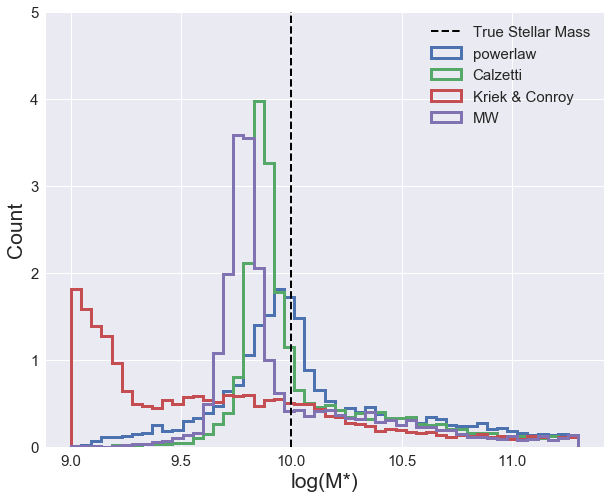

In [148]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(np.log10(mpower), bins=50, range=(9., 11.3), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(np.log10(mCal), bins=50, range=(9., 11.3), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(np.log10(mKC), bins=50, range=(9., 11.3), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(np.log10(mMW), bins=50, range=(9., 11.3), lw=3,histtype='step', density=True, label='MW')
plt.plot([10.0, 10.0], [0, 35], ls='--', lw=2, color='black', label = 'True Stellar Mass')

plt.xlabel('log(M*)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 5])
plt.legend(loc='best', fontsize=15)


#plt.savefig('/Users/sidneylower/Documents/atten_massALL.png', dpi=300)

In [149]:
zpower = [item[1] for item in respower['chain']]
zKC = [item[1] for item in resKC['chain']]
zCal = [item[1] for item in resCal['chain']]
zMW = [item[1] for item in resMW['chain']]

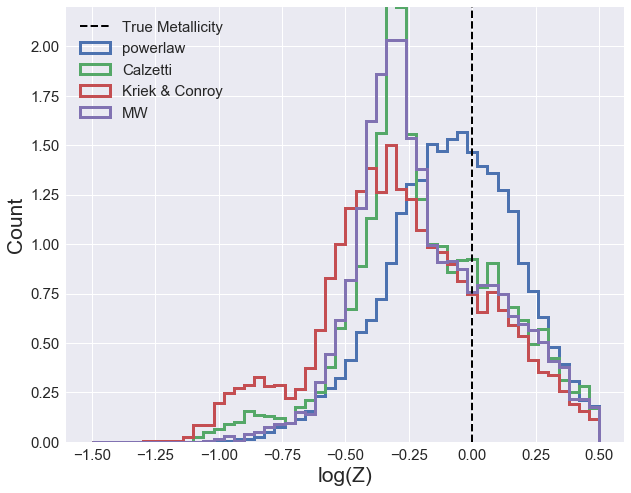

In [150]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(zpower, bins=50, range=(-1.5, 0.5), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(zCal, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(zKC, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(zMW, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='MW')
plt.plot([0.0, 0.0], [0, 35], ls='--', lw=2, color='black', label = 'True Metallicity')

plt.xlabel('log(Z)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 2.2])
plt.legend(loc='upper left', fontsize=15)
#plt.savefig('/Users/sidneylower/Documents/atten_metalALL.png', dpi=300)

In [151]:
agepower = [item[3] for item in respower['chain']]
ageKC = [item[3] for item in resKC['chain']]
ageCal = [item[3] for item in resCal['chain']]
ageMW = [item[3] for item in resMW['chain']]


true_age = 2.0

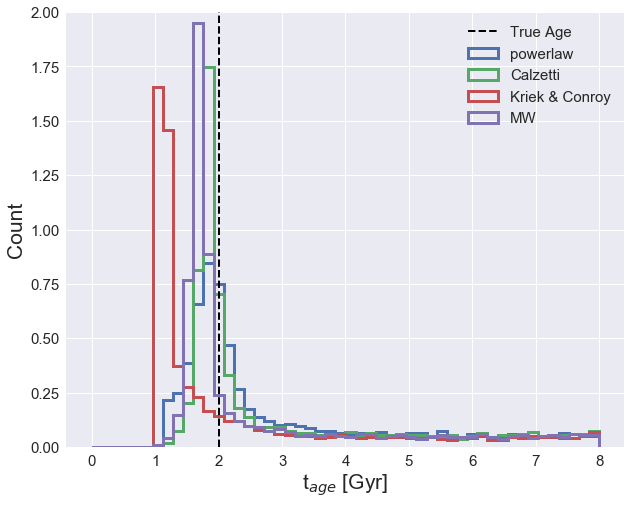

In [152]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(agepower, bins=50, range=(0, 8), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(ageCal, bins=50, range=(0, 8), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(ageKC, bins=50, range=(0, 8), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(ageMW, bins=50, range=(0, 8), lw=3,histtype='step', density=True, label='MW')
plt.plot([true_age, true_age], [0, 35], ls='--', lw=2, color='black', label = 'True Age')

plt.xlabel('t$_{age}$ [Gyr]', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 2])
plt.legend(loc='upper right', fontsize=15)
#plt.savefig('/Users/sidneylower/Documents/age_MW.png', dpi=300)

In [153]:
true_sfr = np.log10((1e10 / (2.0*1.e9)) * (2.0) *np.exp(-(2.0) / 1.0))

In [154]:
mass_distrs = [mpower, mKC, mCal, mMW]
age_distrs = [agepower, ageKC, ageCal, ageMW]
#tau_distrs = [taupower, tauKC, tauCal, tauMW]

#time = 1.0

sfrpower = []
sfrKC = []
sfrCal = []
sfrMW = []
for i in range(len(mpower)):
    sfrpower.append(np.log10((mpower[i] / (agepower[i]*1.e9)) * (agepower[i]) *np.exp(-(agepower[i]) / 1.0)))

for i in range(len(mKC)):
    sfrKC.append(np.log10((mKC[i] / (ageKC[i]*1.e9)) * (ageKC[i]) *np.exp(-(ageKC[i]) / 1.0)))
for i in range(len(mCal)):
    sfrCal.append(np.log10((mCal[i] / (ageCal[i]*1.e9)) * (ageCal[i]) *np.exp(-(ageCal[i]) / 1.0)))
for i in range(len(mMW)):
    sfrMW.append(np.log10((mMW[i] / (ageMW[i]*1.e9)) * (ageMW[i]) *np.exp(-(ageMW[i]) / 1.0)))


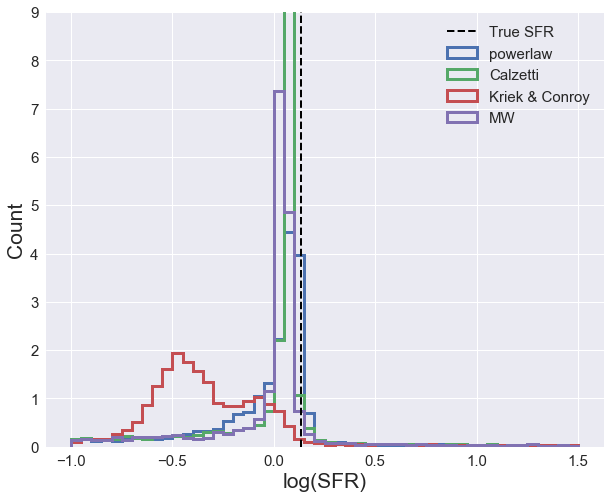

In [155]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
labels = ['powerlaw', 'Kriek & Conroy', 'Calzetti', 'MW']
n, bins, _ = plt.hist(sfrpower, bins=50, range=(-1, 1.5), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(sfrCal, bins=50, range=(-1, 1.5), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(sfrKC, bins=50, range=(-1, 1.5), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(sfrMW, bins=50, range=(-1, 1.5), lw=3,histtype='step', density=True, label='MW')

plt.plot([true_sfr, true_sfr], [0, 35], ls='--', lw=2, color='black', label = 'True SFR')

plt.xlabel('log(SFR)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0,9])
plt.legend(loc='upper right', fontsize=15)
#plt.savefig('/Users/sidneylower/Documents/sfr_all.png', dpi=300)

In [156]:
calzetti = [mCal, zCal, ageCal, sfrCal]
cardelli = [mMW, zMW, ageMW, sfrMW]
kriek_conroy = [mKC, zKC, ageKC, sfrKC]
powerlaw = [mpower, zpower, agepower, sfrpower]
keys = ['log(mass)', 'log(metallicity)', 'age', 'log(sfr)']

In [157]:
mass_dict = {}
mass_dict['calzetti'] = calzetti[0]
mass_dict['cardelli'] = cardelli[0]
mass_dict['kriek_conroy'] = kriek_conroy[0]
mass_dict['powerlaw'] = powerlaw[0]

In [158]:
metal_dict = {}
metal_dict['calzetti'] = calzetti[1]
metal_dict['cardelli'] = cardelli[1]
metal_dict['kriek_conroy'] = kriek_conroy[1]
metal_dict['powerlaw'] = powerlaw[1]

In [159]:
age_dict = {}
age_dict['calzetti'] = calzetti[2]
age_dict['cardelli'] = cardelli[2]
age_dict['kriek_conroy'] = kriek_conroy[2]
age_dict['powerlaw'] = powerlaw[2]

In [160]:
sfr_dict = {}
sfr_dict['calzetti'] = calzetti[3]
sfr_dict['cardelli'] = cardelli[3]
sfr_dict['kriek_conroy'] = kriek_conroy[3]
sfr_dict['powerlaw'] = powerlaw[3]

In [161]:
full_dict = {}
full_dict['mass'] = mass_dict
full_dict['metallicity'] = metal_dict
full_dict['age'] = age_dict
full_dict['log(sfr)'] = sfr_dict

In [162]:
np.savez('/Users/sidneylower/Documents/attenuation_tests_dust1_powerlaw.npz', **full_dict)